
#### IANNwTF WS2020/21
Clara Schier, Johanna Linkemeyer, Marisa Wodrich
# Homework 02

In this homework we implemented a Multi-Layer-Perceptron (MLP) which can be trained on logical gates. For the purpose of the homework, we trained it on the XOR problem, however it can easily be adjusted and trained on other logical gates. 

### 1 Preparation

In [1]:
import numpy as np

We will use sigmoid as our activation function:

In [2]:
# Sigmoid function
def sigmoid(x):
    return 1/(1 + np.exp(-x)) 

# First derivative of sigmoid function
def sigmoidprime(x):
    return sigmoid(x) * (1 - sigmoid(x))

### 2 Data Set

In [3]:
# Possible inputs for our MLP
inputs = np.array([[0,0],[0,1],[1,0],[1,1]])

# Labels / target values for different logical gates
# 0 = false ; 1 = true
t_and = np.array([0,0,0,1])
t_or = np.array([0,1,1,1])
t_nand = np.array([1,1,1,0])
t_nor = np.array([1,0,0,0])
t_xor = np.array([0,1,1,0])

### 3 Perceptron
Disclaimer: This class is to some extend based on the flipped classroom session and was adapted accordingly to fit the present task. The classes functions and the parameters they are given were fixed in the task.

In [4]:
class Perceptron: 
    
    def __init__(self, input_units):
        
        self.input_units = input_units
        
        # Draw random weights and bias from standard normal distribution
        self.weights = np.random.randn(input_units)
        self.bias = np.random.randn()
        
        # Set learning rate
        self.alpha = 1
        
        # Initialize drive and inputs (will be changed during every forward step)
        self.drive = 0
        self.inputs = 0
        
    def forward_step(self, inputs):
      
        self.inputs = inputs
        
        # Calculate drive from weighted inputs and added bias
        self.drive =  self.weights @ inputs + self.bias
        
        # return activated drive
        return sigmoid(self.drive)
        
        
    def update(self, delta):
      
        # Updates 'incoming' weights and bias of a perceptron
        self.weights -= self.alpha * delta * self.inputs
        self.bias -= self.alpha * delta
        

###### Update Step:

function for gradients: $\frac{\delta L}{\delta w_{ij}^{(l)}} = \delta_i^{(l)} a_j^{(l-1)}$

update function: $\theta_{new} = \theta_{old} - \alpha \bigtriangledown L_{\theta}$

### 4 Multi-Layer Perceptron

The class MLP represents a Mutli-Layer-Perceptron, which is build out of 5 perceptrons using the class Perceptron. Its class functions were given in the exercise and their parameters have been adjusted to match the Perceptron.

In [5]:
class MLP():
    
    def __init__(self):
        
        # Initialize 1 hidden layer with 4 perceptrons
        # For our purpose of training logical gates, they will always have 2 inputs
        self.hidden_layer = [Perceptron(2), Perceptron(2), Perceptron(2), Perceptron(2)]
        
        # Initialize 1 output neuron that gets 4 inputs (from the neurons of 
        # the hidden layer)
        self.output_neuron = Perceptron(input_units=4)
        
        # Initialzie inputs and output (will be changed during every forward step)
        self.inputs = np.array([0,0])
        self.output = 0
        
    def forward_step(self, inputs):
        
        self.inputs = inputs
        
        # Perform forward step for each perceptron in hidden layer,   
        # reshape result for further usage
        outputs_hidden_layer = np.asarray([perceptron.forward_step(inputs) for perceptron in self.hidden_layer])
        outputs_hidden_layer = np.reshape(outputs_hidden_layer, newshape=(-1))
        
        # Perform forward step on output perceptron (it takes the outputs from 
        # the hidden layer perceptrons as new inputs)
        self.output = self.output_neuron.forward_step(outputs_hidden_layer)
        
        
    def backprop_step(self, label):
        
        # Calculate error of the output neuron (network error, see below for 
        # formula) and update the perceptrons weights and its bias.
        delta = - (label - self.output)  * sigmoidprime(self.output_neuron.drive)
        self.output_neuron.update(delta)
        
        # Calculate the error for perceptrons in the hidden layer and update 
        # their weights and biases.
        for i, perceptron in enumerate(self.hidden_layer):
            
            # For each neuron in the hidden layer, the error is the error of 
            # the following neuron scaled by their connecting weights and the 
            # activation function's derivative at the postion of the respecitive 
            # neuron's drive.
            delta_p = delta * self.output_neuron.weights[i] * sigmoidprime(perceptron.drive) 
            perceptron.update(delta_p)

###### Calculation of error 

for output neuron:
$\delta_i^{(l)} = - (t_i - y_i) \sigma'(d_i^{(N)})$

for hidden layer neurons:
$\delta_i^{(l)} = (\sum\limits_{k=1}^m \delta_k^{(l+1)}w_{ki}^{(l+1)})\sigma'(d_i^{(l)})$

with $\delta_i^{(l)}$ being the error term delta of a perceptron, $d_i$ being the drive, $w$ the weights, $t_i$ the target value (the label) and $y_i$ the output of the MLP.

### 5 Training

In this section we will define a training function for MLPs and then initialize a MLP instance and train it on the XOR locigal gate for 1000 epochs.

In [6]:
def train_mlp(mlp, epochs, logical_gate):
    
    # Logical gate to train on. Change t to train on a different logical gate 
    # (possible gates: t_and, t_or, t_nand, t_nor, t_xor)
    t = logical_gate

    accuracies = np.zeros(epochs)
    losses = np.zeros(epochs)

    # train for 1000 epochs
    for i in range(epochs):

        # During each epoch, iterate over each data point
        for j in range(4):

            inp = inputs[j]
            target = t[j]  

            # perform one forward and one backward step to adjust parameters
            mlp.forward_step(inp)
            mlp.backprop_step(target)

            # Calculate loss using squared error
            # (Scale with .25 to get average over all four inputs per epoch)
            losses[i] += ((mlp.output - target)**2) * 0.25

            # Calculate accuracy: Output of MLP is float between 0 and 1 and has to 
            # be converted to either 0 or 1 to compare to target.
            # (Again scaling with .25 to get average over all four inputs)
            accuracies[i] += int(round(mlp.output) == target) * 0.25 # int(a == b) turns 1 if a equals b, else 0

    return accuracies, losses

In [7]:
mlp = MLP()

accuracies, losses = train_mlp(mlp, epochs=1000, logical_gate=t_xor)

### 6 Visualization

To evalute the performance of our trained MLP, we will plots its average accuracy and average loss during every training step (epoch) in this section. For that purpose, we created a plotting function that can be used afterwards.

In [8]:
import matplotlib.pyplot as plt

In [9]:
def plot_performance(accuracies, losses, logical_gate):
    # plot the average accuracy for every epoch
    plt.figure(figsize=(15,5))
    plt.plot(accuracies, 'b', label='Accuracy')
    plt.plot(losses, 'r', label='Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Average accuracy / loss")
    plt.legend()
    plt.title("Average accurcy and loss during training of MLP on " + logical_gate + " logical gate")
    plt.show()

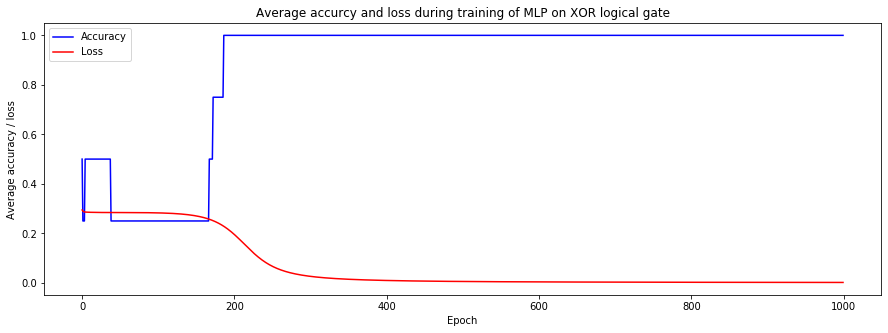

In [10]:
plot_performance(accuracies, losses, "XOR")

## Extra Tasks

#### MLP on different logical gates

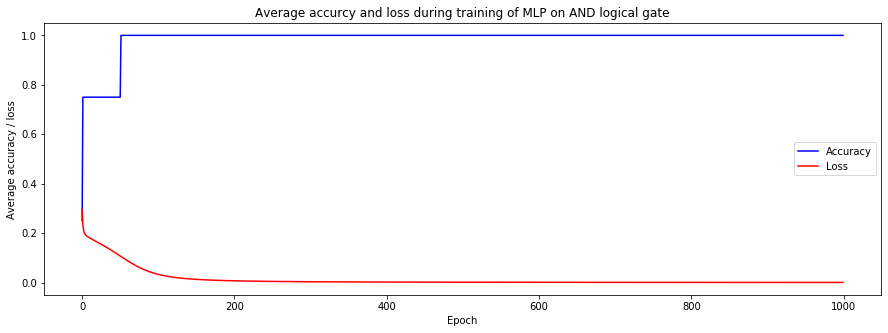

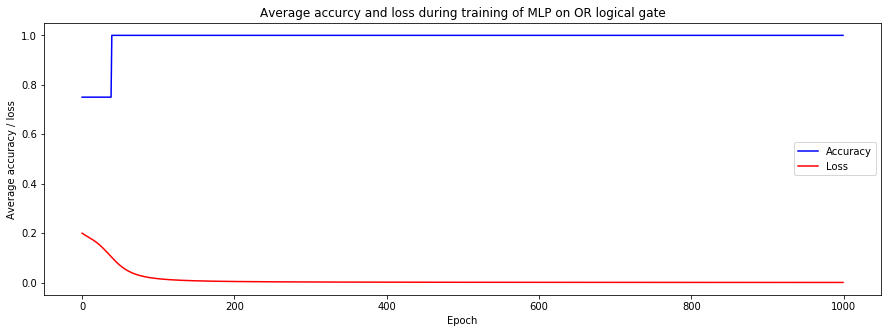

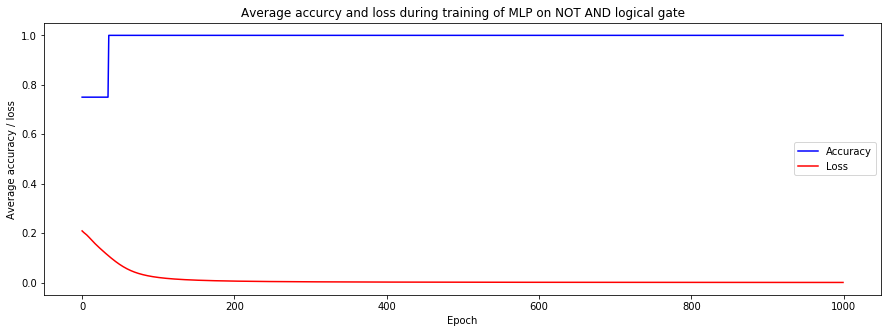

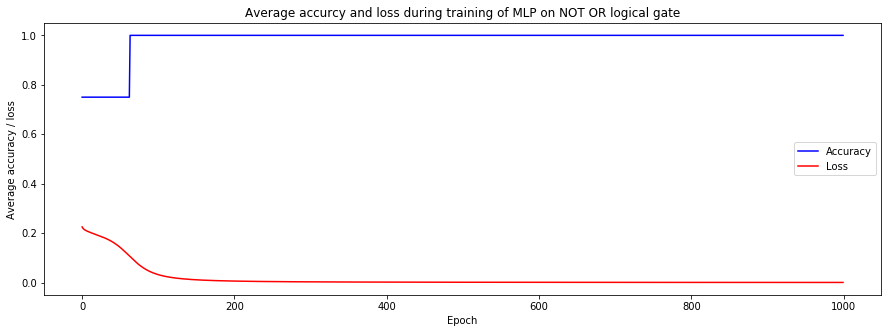

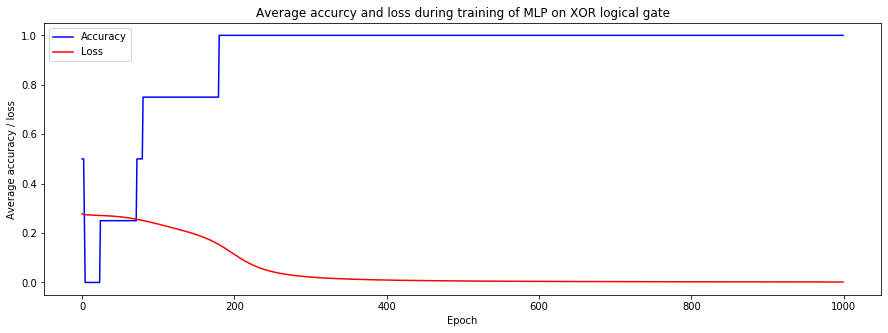

In [11]:
gates = [t_and,t_or,t_nand,t_nor,t_xor]
names = ["AND", "OR", "NOT AND", "NOT OR", "XOR"]

for i, g in enumerate(gates): 
    
    mlp = MLP()
    accuracies, losses = train_mlp(mlp, epochs=1000, logical_gate=g)
    plot_performance(accuracies, losses, names[i])

#### Average time until perfect performance

Next we want to test how long (i.e. how many epochs) it takes for an MLP of our structure to reach an accuracy of 1 (i.e. 100 percent).

In [36]:
# define how many mlps we want to compare
# a higher number is a better for generalizing
# but might take quite long
steps = 20

print("Average time until accuracy of 1 is reached (of " + str(steps) + " MLPs)")

for i, g in enumerate(gates):
    
    average_acc = 0
    
    for _ in range(steps):
        mlp = MLP()
        accuracies, _ = train_mlp(mlp, epochs=1000, logical_gate=g)
        average_acc += (np.argmax(accuracies) + 1) / steps

    print(names[i] + ": " + str(int(average_acc)) + " epochs")


Average time until accuracy of 1 is reached (of 20 MLPs)
AND: 51 epochs
OR: 48 epochs
NOT AND: 67 epochs
NOT OR: 59 epochs
XOR: 255 epochs


The results support what we already knew before: XOR is the only logical operation that is more complicated, as it cannot be seperated linearly. The other ones could also be solved by a single Perceptron, however this is not the case for the XOR problem.